In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
import numpy as np
from pathlib import Path
from itertools import product as myzip

In [3]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [4]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [5]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

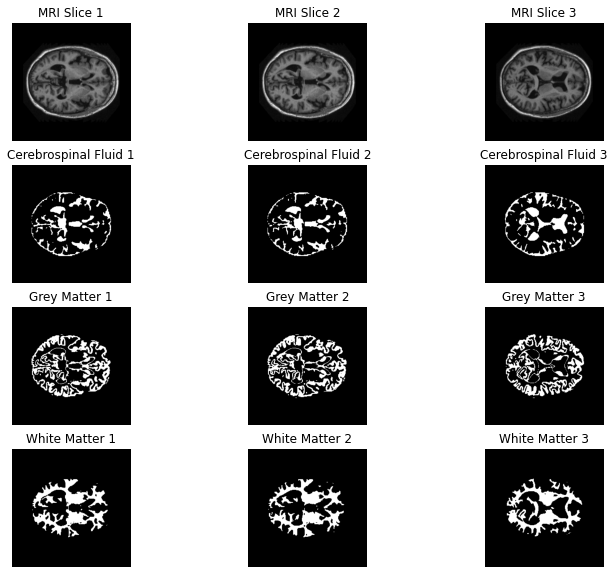

In [6]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [8]:
class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters, f_size=3):
        super(Downshift, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.maxpool_1(x)
        
        return x
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, concatenation, filters, f_size=3):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.concatenate_1 = tf.keras.layers.Concatenate()([concatenation, self.conv2d_1])
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.conv2d_3 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        
    def call(self, x):
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        
        return x

In [39]:
class My_Model(tf.keras.Model):
    def __init__(self):
        super(My_Model, self).__init__()
        self.input = tf.keras.layers.InputLayer()
        self.block_1 = Downshift()

In [27]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 1)),
    keras.layers.Conv2D(10, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
    ])

my_opt = adam(lr=10**-3)

model.compile(optimizer=my_opt, 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 10)      100       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 4)       44        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(data_dict['train'].batch(100), epochs=1,
                    validation_data=data_dict['validate'].batch(100), verbose=1)

Train for 97 steps, validate for 12 steps
97/97 [==============================] - 269s 3s/step - loss: 1.0962 - mean_io_u_7: 0.3750 - val_loss: 1.0423 - val_mean_io_u_7: 0.3750


In [36]:
history.history['loss']

[1.0964277861331473]

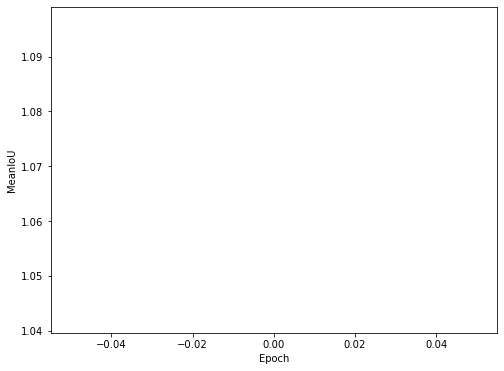

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], 'k', label='Train')
ax.plot(history.history['val_loss'], 'r--', label = 'Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('MeanIoU')
ax.legend

plt.show()

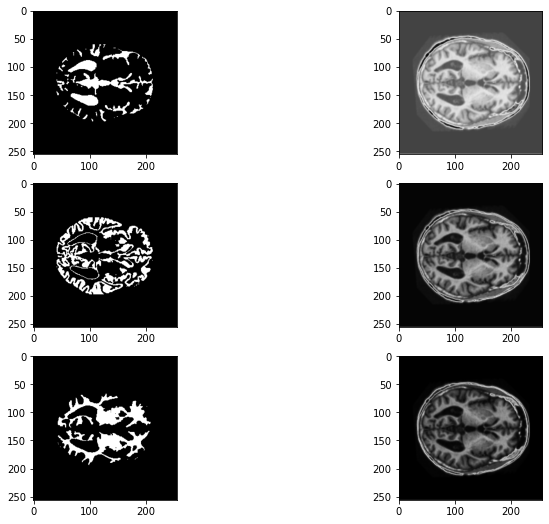

In [47]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')

# for i, j in myzip(range(1), range(1, 4)):
#     ax[0][i].imshow(test_x[i], cmap='gray')
#     ax[0][i].axis('off')
#     ax[0][i].set_title('MRI Slice ' + str(i+1))
    
#     ax[j][i].imshow(test_y_ground[i, :, :, j], cmap='gray')
#     ax[j][i].axis('off')
#     ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [45]:
test_y_predict.shape

(1, 256, 256, 4)